In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

Загрузка библиотеки с FCA

In [2]:
import os
import sys
BASE_PATH = os.path.realpath('..')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

from lib import fca_interp as fcai

# Load Data

In [3]:
from sklearn.datasets import load_boston

boston_data = load_boston()
boston_ds = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston_ds['target'] = boston_data['target']
print(boston_ds.shape)
boston_ds.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
train_feats = list(boston_ds.drop('target',1).columns)
y_feat = 'target'

/root/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



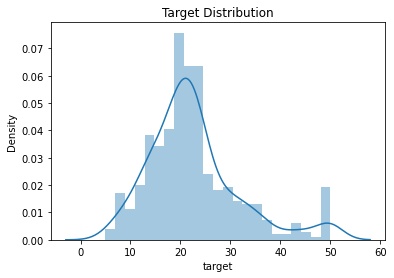

In [5]:
sns.distplot(boston_ds[y_feat])
plt.title('Target Distribution')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,  y_test = train_test_split(boston_ds[train_feats], boston_ds[y_feat], test_size=0.1)
[x.shape for x in [X_train, X_test, y_train,  y_test]]

[(455, 13), (51, 13), (455,), (51,)]

# Check competitors qualities

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
def calc_metrics(model_name, y_train, y_test, preds_train, preds_test, ds_full=None):
    q_dict = {}
    for metric in [mean_absolute_error, mean_squared_error, r2_score]:
        q_dict[(metric.__name__,"train")] = metric(y_train, preds_train)
        q_dict[(metric.__name__,"test")] = metric(y_test, preds_test)
    q_dict_ = {model_name:q_dict}
    q_dict = q_dict_
    del q_dict_
    q_dict = pd.DataFrame(q_dict).reset_index().rename(columns={'level_0':'metric','level_1':'ds'})
    
    if ds_full is not None:
        if model_name in ds_full.columns:
            ds_full = ds_full.drop(model_name, 1)
        ds_full = ds_full.merge(q_dict, on=['metric','ds'])
    else:
        ds_full = q_dict
    return ds_full

In [9]:
def plot_metrics(ds, figsize=(15,5)):
    plt.figure(figsize=figsize)
    for m_idx, metric in enumerate(ds['metric'].unique()):
        cds = ds[ds['metric']==metric]

        plt.subplot(1,3,m_idx+1)
        for ds_idx, ds_type in enumerate(['train','test']):
            vals = cds[cds['ds']==ds_type].drop(['metric','ds'],1).values[0]
            plt.barh(np.arange(len(vals))+0.3*ds_idx, vals, height=0.3, label=ds_type)
            for v_idx, v in enumerate(vals):
                plt.text(v, v_idx-0.05+0.3*ds_idx, f"{v:.2f}")
        plt.legend(loc='lower left')
        plt.yticks(np.arange(cds.shape[1]-2), cds.drop(['metric','ds'],1).columns, rotation=0)
        plt.title(metric)
    plt.tight_layout()
    plt.show()    

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool


models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(),
          XGBRegressor(), CatBoostRegressor()]
comp_qualities = None
for m in tqdm(models):
    if type(m)==CatBoostRegressor:
        p_train, p_test = Pool(X_train, y_train), Pool(X_test, y_test)
        m.fit(p_train, verbose=False)
        preds_train, preds_test = [m.predict(p) for p in [p_train, p_test]]
    else:
        m.fit(X_train, y_train)
        preds_train, preds_test = [m.predict(p) for p in [X_train, X_test]]
    
    comp_qualities = calc_metrics(m.__class__.__name__, y_train, y_test, preds_train, preds_test, comp_qualities)

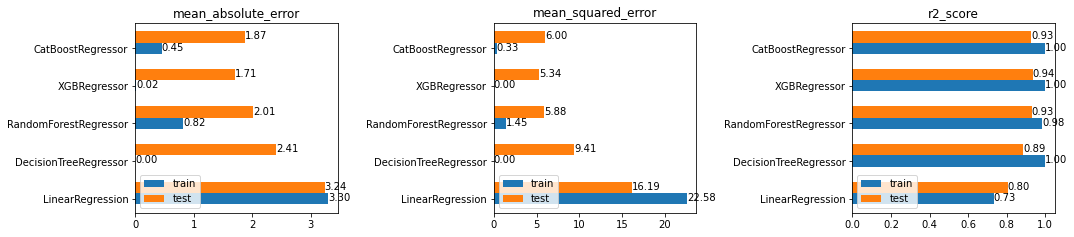

In [11]:
plot_metrics(comp_qualities, figsize=(15,3.4))

# Multi-valued contexts

Работа с узорными структурами.


Сейчас реализованы только:
* интервальная узорная структура ($g^{'} = [a_{min}, a_{max}], \quad g_1^{'}\sqcap g_2^{'} = [min(a_{1_{min}}, a_{2_{min}}), max(a_{1_{max}}, a_{2_{max}}  )],\quad$ где $g$ - объект, $a_{min}, a_{max} \in \mathbb{R}$)
* узорная структура на множествах ($g^{'} = A, \quad g_1^{'}\sqcap g_2^{'} = A_1 \cap A_2,\quad$ где $g$ - объект, $A \subseteq W$,$W$ - множество каких-то значений)

## Lattice construction on big data for supervised learning

На больших контекстах нет смысла рассчитывать все понятия. Будем аппроксимировать решётку через объединение нескольких деревьев решений (про это будет моя магистерская). Возможно такую решётку нельзя будет рассматривать, как средство для KDD (тут лучше пользоваться алгоритмом sofia, который у меня пока не имплементирова), зато её можно использовать для классификации объектов.

### Конструирование аппроксимированной решётки

Делим контекст на обучающую и тестовую выборки.

In [12]:
fcai = reload(fcai)

In [13]:
np.random.seed(42)

mvcntx_train = fcai.MultiValuedContext(X_train, y_true=y_train, cat_attrs=[])
mvcntx_test = fcai.MultiValuedContext(X_test, y_true=y_test, cat_attrs=[])
fm_mv = fcai.FormalManager(mvcntx_train, task_type='Regression')

Строим понятия на обучающей выборке

In [14]:
%%time
fm_mv.construct_concepts(
    use_tqdm=True, algo='RandomForest',
    rf_params={'random_state':42, 'n_estimators':100})
print(len(fm_mv.get_concepts()))


29906
CPU times: user 13.4 s, sys: 195 ms, total: 13.6 s
Wall time: 13.6 s


Небольшой костыль - добавляем в решётку самое меньшее понятие, которое ничего не описывает. Это нужно только для красивой визуализации и корректного расчёта индексов стабильности.

In [15]:
fm_mv._concepts.add(
    fcai.PatternStructure(
        extent=[], intent=None, cat_feats=[],
        idx=len(fm_mv.get_concepts()), metrics={'mean_y_true':0} ) )

Строим остовное дерево на понятиях. Для классификации объектов не обязательно рассчитывать всю решётку, все связи между понятиями.

In [16]:
%%time
fm_mv.construct_lattice(use_tqdm=True, only_spanning_tree=False)


CPU times: user 1h 1min 55s, sys: 8.34 s, total: 1h 2min 3s
Wall time: 1h 1min 50s


Небольшой костыль, чтобы можно было визуализировать получившееся остовное дерево. При расчёте решётки понятий этот код происходит автоматически.

In [17]:
for c in tqdm(fm_mv.get_concepts()):
    c._up_neighbs = {c._up_neighb_st} \
        if c._up_neighb_st is not None else None
    c._low_neighbs = c._low_neighbs_st

fm_mv._calc_concept_levels() # расчёт горизонтальной координаты при отображении понятия

Рассчёт дополнительных метрик для регрессии

Визуализируем остовное дерево

### Классификация с помощью решётки

Алгоритм классификации объекта $g$:
1. Найти множество $C^g$ минимальных (по включению) понятий, которые описывают объект $g$
2. Предсказание для объекта $g$ = среднее из предсказаний каждого понятия из $C^g$

Получаем предсказания для каждого объекта из обучающего и тестового контекстов

In [18]:
%%time
metrics = ['mean_y_true']
preds_train = fm_mv.predict_context(mvcntx_train, metric=metrics)
preds_test = fm_mv.predict_context(mvcntx_test, metric=metrics)
preds_test[[0,10,20]]

CPU times: user 15.3 s, sys: 92.1 ms, total: 15.4 s
Wall time: 15.4 s


matrix([[18.14237853],
        [29.06354307],
        [17.17295079]])

Качество на обучающей и тестовой выборке

In [19]:
comp_qualities = calc_metrics('FCA basic', y_train, y_test, preds_train, preds_test, comp_qualities)

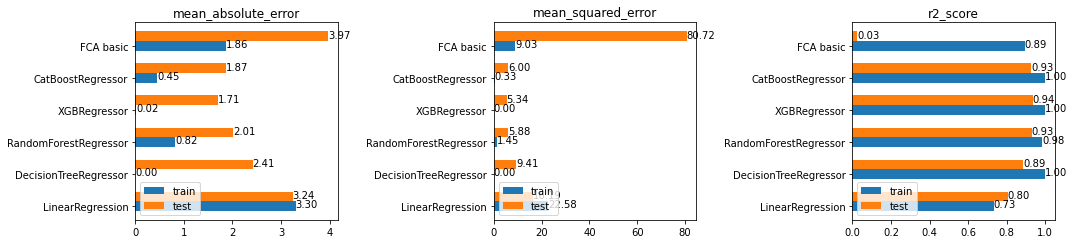

In [20]:
plot_metrics(comp_qualities, (15, 3.5))

# FCA with Linear Regression Weights

In [21]:
def predict_fca(fm, cntx, metric, W, normalized=False, A=None):
    mvals = np.array([c._metrics[metric] for c in fm.sort_concepts()])

    if A is None:
        n_objs, n_cncpts = len(cntx.get_objs()), len(fm.get_concepts())
        
        obj_preds_cncpts = fm.trace_context(cntx)[0]
        
        Acoords = np.array([(1,g, c_id)
                       for g, c_ids in obj_preds_cncpts.items() for c_id in c_ids])
        A = csr_matrix((Acoords[:, 0], (Acoords[:, 1].astype(int), Acoords[:, 2].astype(int))),
                shape=(n_objs, n_cncpts))
    #print(A.shape, mvals.shape)
    Am = A.multiply(mvals)
    
    preds = Am.dot(W)#/(X>0).dot(W) 
    if normalized:
        preds = preds/A.dot(W)
    return preds, A

In [22]:
from scipy.sparse import csr_matrix

In [23]:
def train_rflr(fm, cntx_train, y_train, algo, A_train=None, metric='mean_y_true'):
    n_objs, n_cncpts = len(cntx_train.get_objs()), len(fm.get_concepts())
    W0 =  np.ones(n_cncpts)/n_cncpts
    
    mvals = np.array([c._metrics[metric] for c in fm.sort_concepts()])
    
    if A_train is None:
        n_objs, n_cncpts = len(cntx_train.get_objs()), len(fm.get_concepts())
        
        obj_preds_cncpts = fm.trace_context(cntx_train)[0]
        
        Acoords = np.array([(1,g, c_id)
                       for g, c_ids in obj_preds_cncpts.items() for c_id in c_ids])
        A_train = csr_matrix((Acoords[:, 0], (Acoords[:, 1].astype(int), Acoords[:, 2].astype(int))),
                shape=(n_objs, n_cncpts))
    #print(A.shape, mvals.shape)
    Am = A_train.multiply(mvals)
    
    lr = algo()
    lr.fit(Am, y_train)
    W_lr = lr.coef_
    
    return W_lr

In [24]:
c._metrics

{'mean_y_true': 28.983333333333334}

In [25]:
def balance_weights(fm, W, use_MI=False):
    W1 = W.copy()
    cncpts_dict = {c.get_id():c for c in fm.get_concepts()}
    for c_idx in range(len(fm.get_concepts())-1,-1,-1):
        if W1[c_idx]==0:
            c = cncpts_dict[c_idx]
            mi_weights = np.array([c._metrics['std_y_true']-fm.get_concept_by_id(ln_id)._metrics['std_y_true']
                          for ln_id in c._low_neighbs] if use_MI else np.ones(len(c._low_neighbs)))
            ln_weights = W1[list(c._low_neighbs)]
            W1[c_idx] = (ln_weights*mi_weights).sum()/mi_weights.sum()
    return W1

In [26]:
from sklearn.linear_model import Ridge

All equal weights

In [27]:
W0 = np.ones(len(fm_mv.get_concepts()))/np.ones(len(fm_mv.get_concepts()))*10

In [28]:
preds_train, A_train = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', W0, normalized=True)
preds_test, A_test = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', W0, normalized=True)
preds_test[np.isnan(preds_test)] = y_train.mean()

comp_qualities = calc_metrics('FCA equal weights norm', y_train, y_test, preds_train, preds_test, comp_qualities)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



Linear And Ridge Regression Weights

In [29]:
for algo_name, algo in [('LR',LinearRegression), ('Ridge', Ridge)]:
    W = train_rflr(fm_mv, mvcntx_train, y_train, algo, A_train=A_train)
    Wb = balance_weights(fm_mv, W)

    for is_bal_name, w in [('',W), (' balanced',Wb)]:
        preds_train = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', w, normalized=True, A=A_train)[0]
        preds_test = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', w, normalized=True, A=A_test)[0]
        preds_test[np.isnan(preds_test)] = y_train.mean()
        comp_qualities = calc_metrics(
            f'FCA {algo_name}{is_bal_name} norm',
            y_train, y_test, preds_train, preds_test, comp_qualities
        )

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



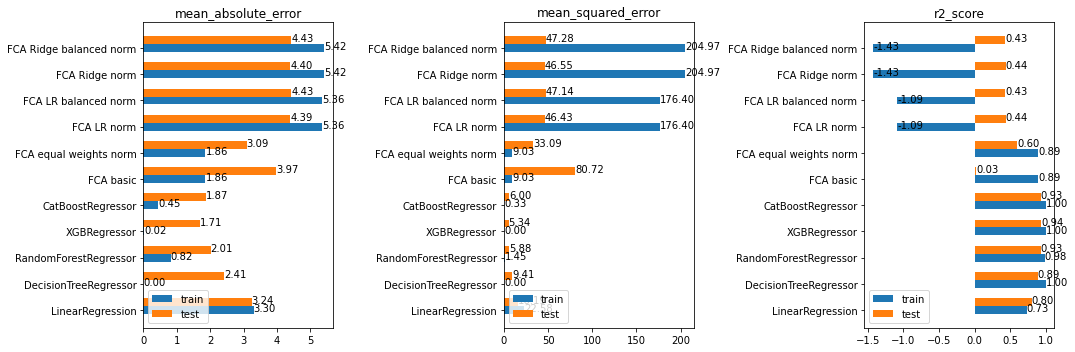

In [30]:
plot_metrics(comp_qualities)

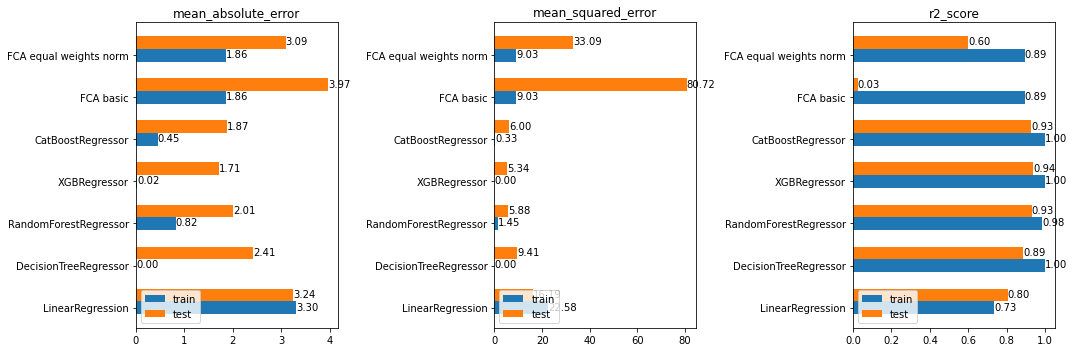

In [31]:
plot_metrics(comp_qualities.drop([f for f in comp_qualities.columns if any([f_ in f for f_ in ['LR','Ridge']])],1))

## Aggregation + Interesting Measures

In [32]:
def predict_fca_top_intermeas(fm, cntx, measure_func, n_top_cncpts, metric='mean_y_true', aggfunc='mean', 
                              obj_preds_cncpts=None):
    wvals = np.array([measure_func(c) for c in fm.sort_concepts()])
    mvals = np.array([c._metrics[metric] for c in fm.sort_concepts()])

    obj_preds_cncpts = fm.trace_context(cntx)[0] if obj_preds_cncpts is None else obj_preds_cncpts
    n_objs, n_cncpts = len(obj_preds_cncpts), len(fm.get_concepts())

    wvals_ths = {g: np.sort(np.unique(wvals[c_ids]))[-n_top_cncpts:].min() if len(c_ids)>0 else None
             for g, c_ids in obj_preds_cncpts.items()}

    if aggfunc == 'mean':
        X_ = np.array([(1,g, c_id)
                       for g, c_ids in obj_preds_cncpts.items()
                       for c_id in c_ids if wvals[c_id]>=wvals_ths[g]])
        X = csr_matrix((X_[:, 0], (X_[:, 1].astype(int), X_[:, 2].astype(int))),
                shape=(n_objs, n_cncpts))
        Xm = X.multiply(mvals)
    
        preds = np.array(Xm.sum(1)/X.sum(1))
    elif aggfunc in ['min','max']:
        dct = {g: [mvals[c_id] for c_id in c_ids if wvals[c_id]>=wvals_ths[g]]
         for g,c_ids in obj_preds_cncpts.items()}
        f_ = min if aggfunc=='min' else max
        preds = np.array([f_(dct[g]) if len(dct[g])>0 else np.nan for g in sorted(dct.keys())]).reshape(-1,1)
    else:
        raise ValueError(f'Unknown aggfunc {aggfunc}. In predict_fca_top_intermeas')
    
    return preds

1 hour to lattice construction

In [33]:
fm_mv.calc_stability_approx(use_tqdm=True)

/opt/lib/fca_interp.py:1009: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:1010: RuntimeWarning:

divide by zero encountered in log2



In [34]:
for c in tqdm(fm_mv.get_concepts()):
    xs = fm_mv.get_context()._y_true[c.get_extent()]
    c._metrics['std_y_true'] = np.nan_to_num(xs.std(ddof=1))
    c._metrics['mae'] = np.abs(xs-xs.mean()).mean()

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [35]:
measure_funcs = {
    'support asc': lambda c: len(c.get_extent()),
    'support desc': lambda c: -len(c.get_extent()),
    'std': lambda c: c._metrics['std_y_true'] if c._metrics['std_y_true']>0 else 1e-9,
    'std inv': lambda c: 1/(1+c._metrics['std_y_true']),
    'std neg': lambda c: -c._metrics['std_y_true'] if c._metrics['std_y_true']>0 else 1e-9,
    'dev': lambda c: c._metrics['std_y_true']**2 if c._metrics['std_y_true']>0 else 1e-9,
    'dev inv': lambda c: 1/(1+c._metrics['std_y_true']**2),
    'dev neg': lambda c: -c._metrics['std_y_true']**2 if c._metrics['std_y_true']>0 else 1e-9,
    'mae': lambda c: c._metrics['mae'] if c._metrics['mae']>0 else 1e-9,
    'mae neg': lambda c: -c._metrics['mae'] if c._metrics['mae']>0 else 1e-9,
    'mae inv': lambda c: 1/(1+c._metrics['mae']),
    'stability asc': lambda c: fcai.get_not_none(c._metrics['log_stab_min_bound'],0),
    'stability desc': lambda c: -fcai.get_not_none(c._metrics['log_stab_min_bound'],1),
}

In [36]:
n_max_objects = A_train.sum(0).max() #max([len(c_ids) for g, c_ids in fm_mv.trace_context(mvcntx_train)[0].items()])

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
%%time
obj_preds_cncpts_train = fm_mv.trace_context(mvcntx_train)[0]
obj_preds_cncpts_test = fm_mv.trace_context(mvcntx_test)[0]

CPU times: user 16.3 s, sys: 3.89 ms, total: 16.3 s
Wall time: 16.3 s


In [39]:
intermeas_qualities = None

for m_func_name, m_func in tqdm(measure_funcs.items()):
    for aggfunc in tqdm(['mean','min','max'], leave=False, desc=m_func_name):
        for n_top_cncpts in tqdm(np.unique(np.linspace(1, n_max_objects, 10).astype(int)), leave=False):
            preds_train = predict_fca_top_intermeas(
                fm_mv, mvcntx_train, m_func, n_top_cncpts,
                aggfunc=aggfunc, obj_preds_cncpts=obj_preds_cncpts_train)
            preds_test = predict_fca_top_intermeas(
                fm_mv, mvcntx_test, m_func, n_top_cncpts,
                aggfunc=aggfunc, obj_preds_cncpts=obj_preds_cncpts_test)
            
            #preds_train = np.nan_to_num(preds_train, nan=fm_mv._top_concept._metrics['mean_y_true'])
            preds_test = np.nan_to_num(preds_test, nan=fm_mv._top_concept._metrics['mean_y_true'])
            
            intermeas_qualities = calc_metrics(
                f"intermeas={m_func_name}_aggfunc={aggfunc}_ncncpts={n_top_cncpts}",
                y_train, y_test, preds_train, preds_test, intermeas_qualities)

In [40]:
cdss= []
for f in intermeas_qualities.drop(['metric','ds'],1).columns:
    cds = intermeas_qualities[['metric','ds',f]].rename(columns={f:'metric_value'})
    cds['type'] = f
    cdss.append(cds)
cds = pd.concat(cdss)
del cdss

In [41]:
cds['interest_measure'] = [x.split('_')[0].split('=')[1] for x in cds['type']]
cds['aggfunc'] = [x.split('_')[1].split('=')[1] for x in cds['type']]
cds['n_top_concepts'] = [int(x.split('_')[2].split('=')[1]) for x in cds['type']]

In [42]:
cds_ = cds[~cds['interest_measure'].isin(['dev','mae','stability asc','stability desc','std','support_asc',
                                         'mae inv','mae neg','dev neg','dev inv','std neg'])]

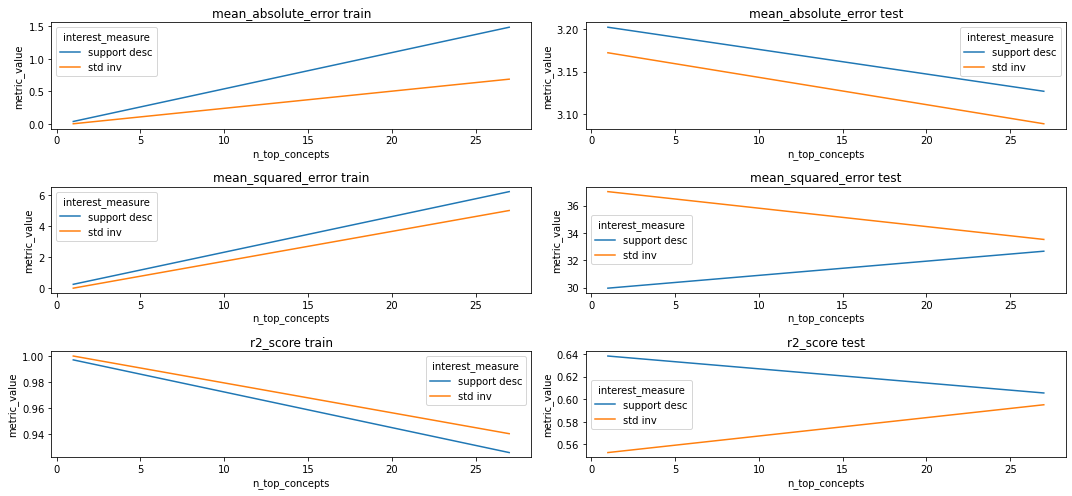

In [43]:
plt.figure(figsize=(15,7))
for m_idx, m in enumerate([m for m in cds_['metric'].unique()]):
    for ds_idx, ds_type in enumerate(['train','test']):
        plt.subplot(3,2,m_idx*2+ds_idx+1)
        sns.lineplot(x='n_top_concepts', y='metric_value', hue='interest_measure',
                     data=cds_[(cds_['aggfunc']=='mean')&(cds_['metric']==m)&(cds_['ds']==ds_type)&
                             (~cds_['interest_measure'].isin(['mae','dev','std','support asc']))&
                              (cds_['n_top_concepts']<50)]
                    )
        plt.title(f"{m} {ds_type}") 
    
plt.tight_layout()
plt.show()

In [44]:
cds[(cds['ds']=='test')&(cds['n_top_concepts']<10)].pivot_table(
    index='interest_measure', columns='metric', values='metric_value', aggfunc='max')

metric,mean_absolute_error,mean_squared_error,r2_score
interest_measure,,,
dev,5.688742,52.625584,0.364353
dev inv,3.172167,37.031766,0.552706
dev neg,3.172167,37.031766,0.552706
mae,6.312734,61.577073,0.256231
mae inv,3.135698,36.469419,0.559498
mae neg,3.135698,36.469419,0.559498
stability asc,5.168014,48.628069,0.545897
stability desc,4.375796,46.546062,0.572151
std,5.688742,52.625584,0.364353


In [45]:
comp_qualities[['metric','ds','LinearRegression','DecisionTreeRegressor','RandomForestRegressor','XGBRegressor','CatBoostRegressor']]

,metric,ds,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,XGBRegressor,CatBoostRegressor
0,mean_absolute_error,test,3.239605,2.413725,2.010882,1.705462,1.872643
1,mean_absolute_error,train,3.301008,0.000000,0.819048,0.019234,0.450407
2,mean_squared_error,test,16.185921,9.414314,5.884042,5.338177,6.001030
3,mean_squared_error,train,22.584632,0.000000,1.450151,0.000734,0.328787
4,r2_score,test,0.804496,0.886288,0.928929,0.935522,0.927516
5,r2_score,train,0.732623,1.000000,0.982832,0.999991,0.996108


# SAMME approach

In [46]:
fm = fm_mv
cntx = mvcntx_train

In [47]:
def fit_fca_samme(fm, cntx, n_iters=20, verb=False, A_train=None):
    Wg = np.ones(len(cntx.get_objs()))/len(cntx.get_objs())
    mses = []
    for idx in range(n_iters):
        W = [np.mean(Wg[c.get_extent()]) for c in fm.sort_concepts()]
        y_pred = predict_fca(fm, cntx, 'mean_y_true',W, normalized=True, A=A_train)[0]

        errv = (y_pred-y_train.values)**2
        Wg = errv/errv.max()
        mses.append(((y_pred-y_train)**2).mean())
        if verb:
            print(f"iter: {idx}, MSE: {mses[-1]}")    
    return W, mses

In [48]:
W, mses = fit_fca_samme(fm, mvcntx_train, n_iters=20, verb=True, A_train=A_train)

iter: 0, MSE: 9.034831435930773
iter: 1, MSE: 6.568641282361307
iter: 2, MSE: 6.036074415286046
iter: 3, MSE: 5.958759217782776
iter: 4, MSE: 5.89450013027754
iter: 5, MSE: 5.885613205351911
iter: 6, MSE: 5.879922991386904
iter: 7, MSE: 5.8770907553665
iter: 8, MSE: 5.877721004635373
iter: 9, MSE: 5.8765830884842485
iter: 10, MSE: 5.877170568831837
iter: 11, MSE: 5.876733700325464
iter: 12, MSE: 5.876984458254213
iter: 13, MSE: 5.876827547062586
iter: 14, MSE: 5.876918520708964
iter: 15, MSE: 5.876864693168764
iter: 16, MSE: 5.876895733995683
iter: 17, MSE: 5.876877765162477
iter: 18, MSE: 5.876888068621052
iter: 19, MSE: 5.876882160558166


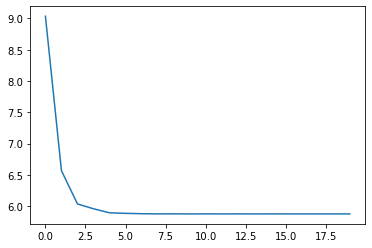

In [49]:
plt.plot(mses)

# Other Boosting Approach

Условный алгоритм:
0. Назначаем всем понятиям одинаковый вес
1. Считаем предсказание решётки
2. Считаем ошибку предсказания на каждом объекте. ошибка>=0
3. Для каждого понятия, использовавшегося для предсказания посчитать среднее расстояние от его предсказания до истинного значения
4. Чем больше среднее расстояние - тем меньший вес дать понятию
5. Для понятий, не использовавшихся в предсказании, поставить вес как средний вес их детей

In [50]:
lr = 1e-3

In [51]:
mvals = [c._metrics['mean_y_true'] for c in fm.sort_concepts()]

In [52]:
mses = []
W_new = np.ones(len(fm.get_concepts()))/len(fm.get_concepts())
for idx in range(30):
    W = W_new
    y_pred = predict_fca(fm, cntx, 'mean_y_true',W, normalized=True, A=A_train)[0]
    mses.append(((y_pred-y_train)**2).mean())
    if True:
        print(f"iter: {idx}, MSE: {mses[-1]}, MAE: {(y_pred-y_train).abs().mean()}")    
    
    Xerr = (A_train.T.multiply(y_train).T-A_train.multiply(mvals))
    #Xerr = (A_train.T.multiply((y_train-y_pred))).T
    Xerr = Xerr.multiply(Xerr)
    Xerr = Xerr.sqrt() #log1p()    
    dW = -np.asarray(Xerr.sum(0)/A_train.sum(0)).flatten()
    W_new = np.nan_to_num(W+lr*dW)
    W_new = balance_weights(fm_mv, W_new, use_MI=False)
    W_new = np.nan_to_num(W_new)
    W_new = (W_new-W_new.min())/(W_new.max()-W_new.min())

iter: 0, MSE: 9.034831435930824, MAE: 1.8585679237086703
iter: 1, MSE: 8.748912618994975, MAE: 1.8211832238463272
iter: 2, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 3, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 4, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 5, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 6, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 7, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 8, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 9, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 10, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 11, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 12, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 13, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 14, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 15, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 16, MSE: 8.748912618994975, MAE: 1.8211832238463277
iter: 17, MSE: 8.7489126

In [53]:
y_pred = predict_fca(fm, mvcntx_test, 'mean_y_true',W, normalized=True, A=A_test)[0]

In [54]:
y_pred = np.nan_to_num(y_pred, nan=fm_mv.get_concept_by_id(0)._metrics['mean_y_true'])

In [55]:
(y_test-y_pred).abs().mean()

3.092973322381485

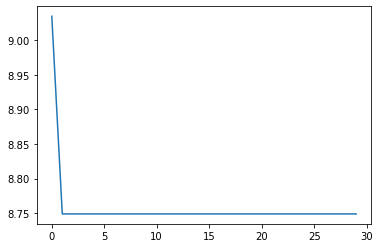

In [56]:
plt.plot(mses)

In [57]:
y_pred = predict_fca(fm, cntx, 'mean_y_true',W, normalized=True, A=A_train)[0]

In [58]:
Xerr = (A_train.T.multiply(y_train).T-A_train.multiply(mvals))
Xerr = Xerr.multiply(Xerr)
Xerr = Xerr.log1p()

In [59]:
dW = -np.asarray(Xerr.sum(0)/A_train.sum(0)).flatten()
dW.shape, dW

((29907,), array([nan, nan, nan, ..., -0., -0., nan]))

In [60]:
W_new = np.nan_to_num(W+lr*dW)
W_new = balance_weights(fm_mv, W_new)
W_new = np.nan_to_num(W_new)
W_new = (W_new-W_new.min())/(W_new.max()-W_new.min())

In [61]:
W = W_new